# Keras to Tensorflow Model

In [1]:
import keras
import keras.backend as K
import tensorflow as tf
import numpy as np
np.random.seed(0)
import segmentation_models as sm
import sys
import os
sys.path.append("..")
from seg_net.data import *
from seg_net.fast_scnn import fast_scnn
from seg_net.dlv3 import Deeplabv3
from seg_net.gunet import Unet
from seg_net.MMNet import MMNet, custom_loss

Using TensorFlow backend.
/home/avantariml/.local/lib/python3.5/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


## Set Model Architecture

In [2]:
INPUT_SHAPE =  (256,256,3) #(768,768,3) (512,512,3) (256,256,3)
NUM_CLASS = 1
BACKBONE = 'mobilenetv2'
MODEL_NAME = 'MMNet'
LOSS_METRICS = 'MSE_ACC_IOU'
ACTIVATION = 'sigmoid'
DATASET = "train_matte"
IMGNORM = 'divide'
MODEL_PATH_ = '../results/Models/MMNet'

model_fname = '{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}'.format(BACKBONE,
                                                MODEL_NAME,
                                                LOSS_METRICS,
                                                IMGNORM,
                                                NUM_CLASS,
                                                ACTIVATION,
                                                INPUT_SHAPE[0],
                                                DATASET)

MODEL_PATH = '../results/Models/GraphModels'

keras_filename = '{}_EncFrozen.hdf5'.format(model_fname)
pb_filename = '{}_EncFrozen.pb'.format(model_fname)
pb_op_filename = '{}_op_EncFrozen.pb'.format(model_fname)
mlmodel_filename = '{}_EncFrozen.mlmodel'.format(model_fname)
mlmodel_fp16_filename = '{}_fp16_EncFrozen.mlmodel'.format(model_fname)
mlmodel_Q_filename = '{}_Q_EncFrozen.mlmodel'.format(model_fname)
tflite_filename = '{}_EncFrozen.tflite'.format(model_fname)
tflite_Q_filename = '{}_Q_EncFrozen.tflite'.format(model_fname)

## Build and Load Model

In [3]:
model, endpoints = MMNet(pretrained = None,
                         backbone = BACKBONE,
                         input_shape = INPUT_SHAPE,
                         input_tensor=None,
                         classes = NUM_CLASS,
                         depth_multiplier = 1.0,
                         activation = ACTIVATION,
                         freeze_encoder = False)

Instructions for updating:
Colocations handled automatically by placer.


../seg_net/mobilenet_v2.py:319: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [4]:
model = Unet(pretrained = None,
             backbone = BACKBONE,
             input_shape = INPUT_SHAPE,
             classes = NUM_CLASS,
             activation = ACTIVATION,
             sep_conv = True,
             densenet_matting_filters = 16,
             densenet_matting_layers = 3,
             matt_sep_conv = True,
             freeze_encoder = False,
             decoder_filters = (256,128,64,32,16),
             n_upsample_blocks=5)

Instructions for updating:
Colocations handled automatically by placer.


../seg_net/mobilenet_v2.py:319: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [3]:
model = sm.Linknet(BACKBONE, encoder_weights='imagenet', 
                  classes=NUM_CLASS,
                  activation=ACTIVATION,
                  input_shape = INPUT_SHAPE)

Instructions for updating:
Colocations handled automatically by placer.


/home/avantariml/.local/lib/python3.5/site-packages/segmentation_models/backbones/mobilenetv2.py:273: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [3]:
model = fast_scnn(input_shape = INPUT_SHAPE, 
                  num_classes = NUM_CLASS, 
                  activation = ACTIVATION, 
                  dropout_rate = 0.3,
                  backbone_name = BACKBONE)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model = Deeplabv3(weights=None, 
                  input_shape=INPUT_SHAPE, 
                  backbone=BACKBONE,
                  classes=NUM_CLASS, 
                  OS=8,
                  activation=ACTIVATION)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
model.load_weights(os.path.join(MODEL_PATH_,keras_filename))
print("Loading from ",os.path.join(MODEL_PATH_,keras_filename))

Loading from  ../results/Models/MMNet/mobilenetv2_MMNet_MSE_ACC_IOU_divide_1_sigmoid_256_train_matte_EncFrozen.hdf5


In [8]:
model.compile('sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.save(os.path.join(MODEL_PATH_,keras_filename))

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## save keras model as tf .pb and as CoreML .mlmodel

In [6]:
from tensorflow.python.tools.optimize_for_inference_lib import optimize_for_inference
import coremltools
from seg_net.keras_to_tensorflow import *

In [7]:
input_node_names = [node.op.name for node in model.inputs]
print(input_node_names)

['input_1']


In [8]:
# output_names
output_node_names = [node.op.name for node in model.outputs]
print(output_node_names)

['activation_1/Sigmoid']


### Freezing the model to .pb

In [9]:
const_graphDef = freeze_keras(K.get_session(), output_node_names, transform = None, 
                              clear_devices = True, add_tf_global = False)
tf.train.write_graph(const_graphDef, MODEL_PATH, pb_filename, as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


INFO:tensorflow:Froze 366 variables.


INFO:tensorflow:Froze 366 variables.


INFO:tensorflow:Converted 366 variables to const ops.


INFO:tensorflow:Converted 366 variables to const ops.


'../results/Models/GraphModels/mobilenetv2_MMNet_MSE_ACC_IOU_divide_1_sigmoid_256_train_matte_EncFrozen.pb'

In [10]:
for name in [n.name for n in const_graphDef.node]:
    print(name)

input_1
Conv1_pad/Pad/paddings
Conv1_pad/Pad
Conv1/kernel
Conv1/kernel/read
Conv1/convolution
bn_Conv1/gamma
bn_Conv1/gamma/read
bn_Conv1/beta
bn_Conv1/beta/read
bn_Conv1/moving_mean
bn_Conv1/moving_mean/read
bn_Conv1/moving_variance
bn_Conv1/moving_variance/read
bn_Conv1/Const_4
bn_Conv1/Const_5
bn_Conv1/FusedBatchNorm
bn_Conv1/keras_learning_phase/input
bn_Conv1/keras_learning_phase
bn_Conv1/cond/pred_id
bn_Conv1/cond/Switch_1
bn_Conv1/cond/FusedBatchNorm
bn_Conv1/cond/FusedBatchNorm/Switch
bn_Conv1/cond/FusedBatchNorm/Switch_1
bn_Conv1/cond/FusedBatchNorm/Switch_2
bn_Conv1/cond/FusedBatchNorm/Switch_3
bn_Conv1/cond/FusedBatchNorm/Switch_4
bn_Conv1/cond/Merge
Conv1_relu/Relu6
expanded_conv_depthwise/depthwise_kernel
expanded_conv_depthwise/depthwise_kernel/read
expanded_conv_depthwise/depthwise
expanded_conv_depthwise_BN/gamma
expanded_conv_depthwise_BN/gamma/read
expanded_conv_depthwise_BN/beta
expanded_conv_depthwise_BN/beta/read
expanded_conv_depthwise_BN/moving_mean
expanded_conv

In [11]:
opt_graphDef = optimize_for_inference(const_graphDef,
                                   input_node_names,
                                   output_node_names,
                                   tf.float32.as_datatype_enum,
                                   toco_compatible=True)
tf.train.write_graph(opt_graphDef, MODEL_PATH, pb_op_filename, as_text=False)

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes


'../results/Models/GraphModels/mobilenetv2_MMNet_MSE_ACC_IOU_divide_1_sigmoid_256_train_matte_op_EncFrozen.pb'

### keras to .tflite

In [12]:
tf.keras.losses.custom_loss = sm.losses.bce_dice_loss

In [49]:
'''converter = tf.lite.TFLiteConverter.from_keras_model_file(os.path.join(MODEL_PATH_,keras_filename))
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH,tflite_filename), "wb") as f:
    f.write(tflite_model)'''

'converter = tf.lite.TFLiteConverter.from_keras_model_file(os.path.join(MODEL_PATH_,keras_filename))\nconverter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,\n                        tf.lite.OpsSet.SELECT_TF_OPS]\ntflite_model = converter.convert()\nwith open(os.path.join(MODEL_PATH,tflite_filename), "wb") as f:\n    f.write(tflite_model)'

In [48]:
'''converter_Q = tf.lite.TFLiteConverter.from_keras_model_file(os.path.join(MODEL_PATH_,keras_filename))
converter_Q.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]
converter_Q.post_training_quantize=True
tflite_Q_model = converter_Q.convert()
with open(os.path.join(MODEL_PATH,tflite_Q_filename), "wb") as f:
    f.write(tflite_Q_model)'''

'converter_Q = tf.lite.TFLiteConverter.from_keras_model_file(os.path.join(MODEL_PATH_,keras_filename))\nconverter_Q.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,\n                        tf.lite.OpsSet.SELECT_TF_OPS]\nconverter_Q.post_training_quantize=True\ntflite_Q_model = converter_Q.convert()\nwith open(os.path.join(MODEL_PATH,tflite_Q_filename), "wb") as f:\n    f.write(tflite_Q_model)'

In [13]:
# Converting a tf.keras model.
converter = tf.lite.TFLiteConverter.from_session(K.get_session(), model.inputs, model.outputs)
converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
with open(os.path.join(MODEL_PATH,tflite_filename), "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Froze 366 variables.


INFO:tensorflow:Froze 366 variables.


INFO:tensorflow:Converted 366 variables to const ops.


INFO:tensorflow:Converted 366 variables to const ops.


In [14]:
# Converting a tf.keras model.
converter_Q = tf.lite.TFLiteConverter.from_session(K.get_session(), model.inputs, model.outputs)
converter_Q.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                        tf.lite.OpsSet.SELECT_TF_OPS]
converter_Q.post_training_quantize=True
tflite_Q_model = converter_Q.convert()
with open(os.path.join(MODEL_PATH,tflite_Q_filename), "wb") as f:
    f.write(tflite_Q_model)

INFO:tensorflow:Froze 366 variables.


INFO:tensorflow:Froze 366 variables.


INFO:tensorflow:Converted 366 variables to const ops.


INFO:tensorflow:Converted 366 variables to const ops.


### keras to .mlmodel

In [16]:
coremltools.models.neural_network.NeuralNetworkBuilder.add_resize_bilinear()

TypeError: add_resize_bilinear() missing 4 required positional arguments: 'self', 'name', 'input_name', and 'output_name'

In [17]:
def convert_lambda(layer):
    from coremltools.proto import NeuralNetwork_pb2
    params = NeuralNetwork_pb2.CustomLayerParams()
    # The name of the Swift or Obj-C class that implements this layer.
    params.className = "resize_bilinear"
    # The desciption is shown in Xcode's mlmodel viewer.
    params.description = "A resize function"
    return params

coreml_model = coremltools.converters.keras.convert(model,
                                                    input_names=input_node_names,
                                                    image_input_names=input_node_names,
                                                    output_names=output_node_names,
                                                    image_scale=1/255.0,
                                                    add_custom_layers=True,
                                                    custom_conversion_functions={ "Lambda": convert_lambda }
                                                   )

0 : input_1, <keras.engine.input_layer.InputLayer object at 0x7ff60319b898>
1 : Conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x7ff60319bcc0>
2 : Conv1, <keras.layers.convolutional.Conv2D object at 0x7ff60319bc88>
3 : bn_Conv1, <keras.layers.normalization.BatchNormalization object at 0x7ff6031c9208>
4 : Conv1_relu, <keras.layers.advanced_activations.ReLU object at 0x7ff6031c98d0>
5 : expanded_conv_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7ff631625c18>
6 : expanded_conv_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff6031c9ef0>
7 : expanded_conv_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x7ff6000d64e0>
8 : expanded_conv_project, <keras.layers.convolutional.Conv2D object at 0x7ff600061710>
9 : expanded_conv_project_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff60002c7b8>
10 : block_1_expand, <keras.layers.convolutional.Conv2D object at 0x7ff5f0781e10>
11 : block_1_expand_BN,

92 : block_10_expand_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff59045fd68>
93 : block_10_expand_relu, <keras.layers.advanced_activations.ReLU object at 0x7ff5903fd710>
94 : block_10_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7ff5903858d0>
95 : block_10_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff590355630>
96 : block_10_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x7ff5902beda0>
97 : block_10_project, <keras.layers.convolutional.Conv2D object at 0x7ff59029a6a0>
98 : block_10_project_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff59024d710>
99 : block_11_expand, <keras.layers.convolutional.Conv2D object at 0x7ff590235d68>
100 : block_11_expand_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff590193e10>
101 : block_11_expand_relu, <keras.layers.advanced_activations.ReLU object at 0x7ff590130ac8>
102 : block_11_depthwise, <keras.layers.convolutional.Dept

181 : decoder_stage1_2_pointwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff58146e4a8>
182 : activation_8, <keras.layers.core.Activation object at 0x7ff58140b630>
183 : lambda_3, <keras.layers.core.Lambda object at 0x7ff58139b4a8>
184 : concatenate_3, <keras.layers.merge.Concatenate object at 0x7ff5813fc400>
185 : decoder_stage2_1_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7ff5812d3f60>
186 : decoder_stage2_1_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff58127ef60>
187 : activation_9, <keras.layers.core.Activation object at 0x7ff58127ef98>
188 : decoder_stage2_1_pointwise, <keras.layers.convolutional.Conv2D object at 0x7ff5812aa278>
189 : decoder_stage2_1_pointwise_BN, <keras.layers.normalization.BatchNormalization object at 0x7ff581261ef0>
190 : activation_10, <keras.layers.core.Activation object at 0x7ff5811fe780>
191 : decoder_stage2_2_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x7ff58

In [18]:
# Look at the layers in the converted Core ML model.
print("\nLayers in the converted model:")
for i, layer in enumerate(coreml_model._spec.neuralNetwork.layers):
    if layer.HasField("custom"):
        print("Layer %d = %s --> custom layer = %s" % (i, layer.name, layer.custom.className))
    else:
        print("Layer %d = %s" % (i, layer.name))


Layers in the converted model:
Layer 0 = Conv1_pad
Layer 1 = Conv1
Layer 2 = bn_Conv1
Layer 3 = Conv1_relu
Layer 4 = Conv1_relu__neg__
Layer 5 = Conv1_relu__clip__
Layer 6 = Conv1_relu_neg2
Layer 7 = expanded_conv_depthwise
Layer 8 = expanded_conv_depthwise_BN
Layer 9 = expanded_conv_depthwise_relu
Layer 10 = expanded_conv_depthwise_relu__neg__
Layer 11 = expanded_conv_depthwise_relu__clip__
Layer 12 = expanded_conv_depthwise_relu_neg2
Layer 13 = expanded_conv_project
Layer 14 = expanded_conv_project_BN
Layer 15 = block_1_expand
Layer 16 = block_1_expand_BN
Layer 17 = block_1_expand_relu
Layer 18 = block_1_expand_relu__neg__
Layer 19 = block_1_expand_relu__clip__
Layer 20 = block_1_expand_relu_neg2
Layer 21 = block_1_pad
Layer 22 = block_1_depthwise
Layer 23 = block_1_depthwise_BN
Layer 24 = block_1_depthwise_relu
Layer 25 = block_1_depthwise_relu__neg__
Layer 26 = block_1_depthwise_relu__clip__
Layer 27 = block_1_depthwise_relu_neg2
Layer 28 = block_1_project
Layer 29 = block_1_proje

In [19]:
spec = coreml_model.get_spec()
print(spec.description)

input {
  name: "input_1"
  type {
    imageType {
      width: 256
      height: 256
      colorSpace: RGB
    }
  }
}
output {
  name: "sigmoid/Sigmoid"
  type {
    multiArrayType {
      shape: 1
      shape: 256
      shape: 256
      dataType: DOUBLE
    }
  }
}



In [20]:
coreml_model.save(os.path.join(MODEL_PATH, mlmodel_filename))

In [21]:
model =  coremltools.models.MLModel(os.path.join(MODEL_PATH, mlmodel_filename))

In [22]:
model_fp16_spec = coremltools.utils.convert_neural_network_weights_to_fp16(coreml_model)
model_fp16_spec.save(os.path.join(MODEL_PATH, mlmodel_fp16_filename))
#coremltools.utils.save_spec(model_fp16_spec, os.path.join(MODEL_PATH, mlmodel_fp16_filename))

In [23]:
quantized_coreml_spec = coremltools.models.neural_network.quantization_utils.quantize_weights(coreml_model,8) 
coremltools.utils.save_spec(quantized_coreml_spec, os.path.join(MODEL_PATH, mlmodel_Q_filename))

Quantizing using linear quantization
Optimizing Neural Network before Quantization:
Fused Conv1->bn_Conv1
Fused expanded_conv_depthwise->expanded_conv_depthwise_BN
Fused expanded_conv_project->expanded_conv_project_BN
Fused block_1_expand->block_1_expand_BN
Fused block_1_depthwise->block_1_depthwise_BN
Fused block_1_project->block_1_project_BN
Fused block_2_expand->block_2_expand_BN
Fused block_2_depthwise->block_2_depthwise_BN
Fused block_2_project->block_2_project_BN
Fused block_3_expand->block_3_expand_BN
Fused block_3_depthwise->block_3_depthwise_BN
Fused block_3_project->block_3_project_BN
Fused block_4_expand->block_4_expand_BN
Fused block_4_depthwise->block_4_depthwise_BN
Fused block_4_project->block_4_project_BN
Fused block_5_expand->block_5_expand_BN
Fused block_5_depthwise->block_5_depthwise_BN
Fused block_5_project->block_5_project_BN
Fused block_6_expand->block_6_expand_BN
Fused block_6_depthwise->block_6_depthwise_BN
Fused block_6_project->block_6_project_BN
Fused block_7_

## load & inference the model

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import skimage
import glob
import os
import cv2

In [16]:
# Load Test Images
path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(path,"*.jpg")))
images = []
images_ = []
for f in fnames:
    img = skimage.io.imread(f)
    img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
    img_ = preprocess_input(img_, imgNorm=IMGNORM)
    images_.append(img_)
    images.append(img)

In [17]:
sess = tf.Session()

In [18]:
# load model from pb file
with tf.gfile.GFile(os.path.join(MODEL_PATH,pb_op_filename),'rb') as f:
#pb_op_filename = "/media/new_hdd2/seg_net/results/Models/GraphModels/mobilenetv2_Linknet_BCE_ACC_IOU_divide_1_sigmoid_512_train_matte_Qotp.pb"
#with tf.gfile.GFile(os.path.join(MODEL_PATH,pb_filename),'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    g_in = tf.import_graph_def(graph_def)
print("Loading from ",os.path.join(MODEL_PATH,pb_filename))

Loading from  ../results/Models/GraphModels/mobilenetv2_MMNet_MSE_ACC_IOU_divide_1_sigmoid_256_train_matte_EncFrozen.pb


In [19]:
tensor_output = sess.graph.get_tensor_by_name('import/activation_1/Sigmoid:0')#'import/sigmoid/Sigmoid:0'
tensor_input = sess.graph.get_tensor_by_name('import/input_1:0')
outs = []

In [20]:
%%timeit
_ = sess.run(tensor_output, {tensor_input: images_[0]})

4.99 ms ± 523 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
for img_ in images_:
    # inference by the model (op name must comes with :0 to specify the index of its output)
    output = sess.run(tensor_output, {tensor_input: img_})
    outs.append(np.squeeze(output))

In [22]:
sess.close()

/home/avantariml/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


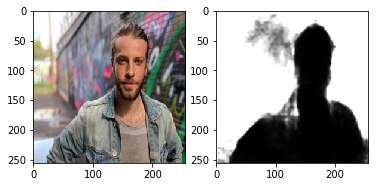

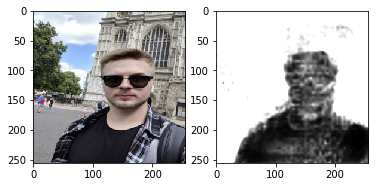

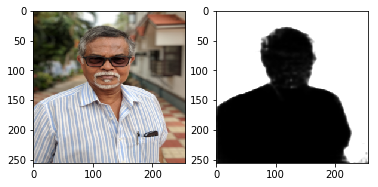

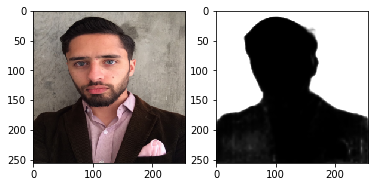

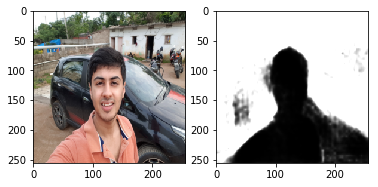

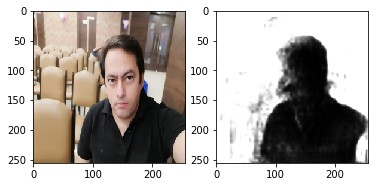

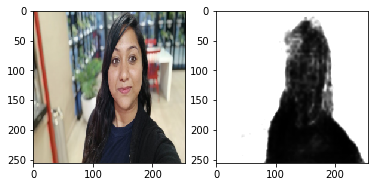

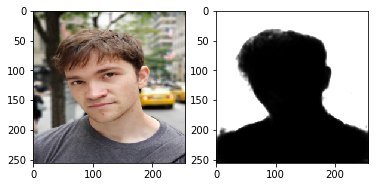

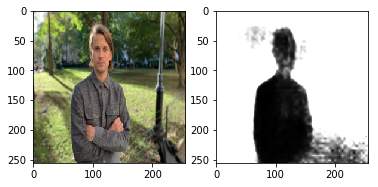

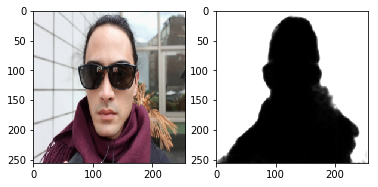

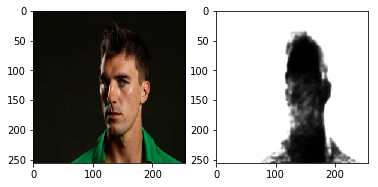

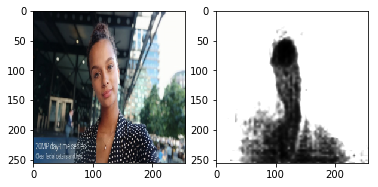

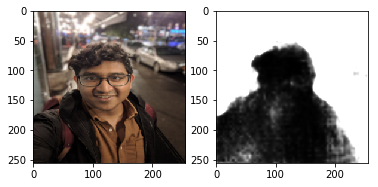

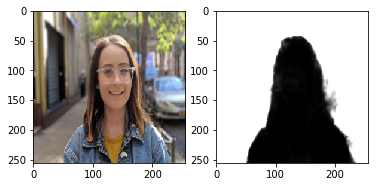

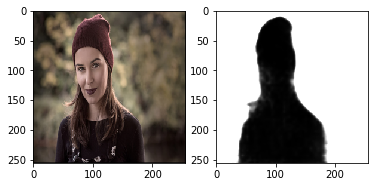

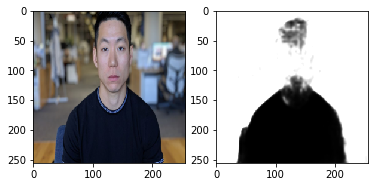

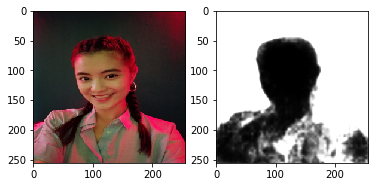

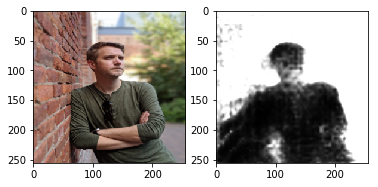

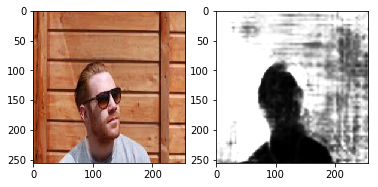

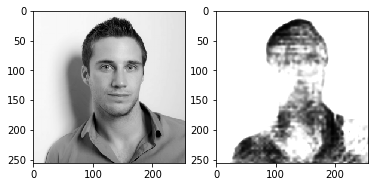

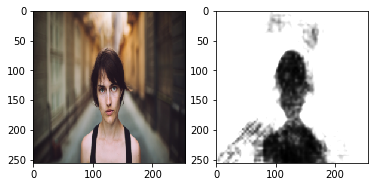

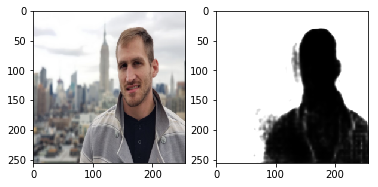

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,otp.shape,anti_aliasing=True))
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1), cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')

### Testing TFLite model using Python API

In [24]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_PATH,tflite_filename))
#interpreter = tf.lite.Interpreter(model_path=os.path.join(MODEL_PATH,tflite_Q_filename))
#interpreter = tf.lite.Interpreter(model_path="/media/new_hdd2/seg_net/results/Models/Models/sample_tf.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details[0]['shape']
outs = []

In [25]:
import random
i = random.choice(range(0,len(fnames)))
inp = np.copy(images[i])
img_ = np.copy(images_[i])

In [26]:
%%timeit
interpreter.set_tensor(input_details[0]['index'], img_)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

39.9 ms ± 701 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%%time
for img_ in images_:
    # inference by the model (op name must comes with :0 to specify the index of its output)
    interpreter.set_tensor(input_details[0]['index'], img_)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    outs.append(np.squeeze(output))

CPU times: user 1.69 s, sys: 27.1 ms, total: 1.72 s
Wall time: 890 ms


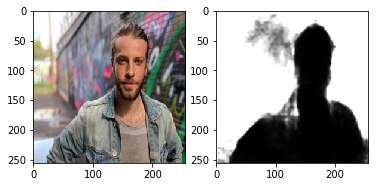

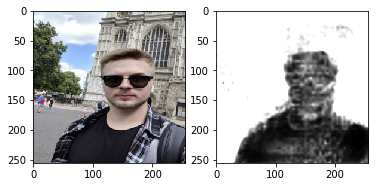

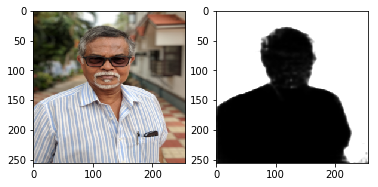

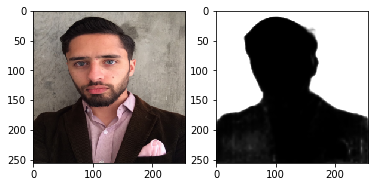

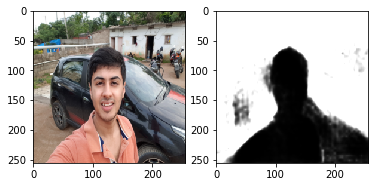

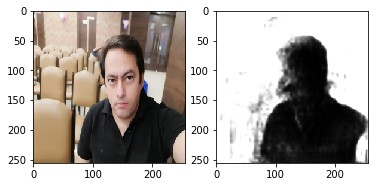

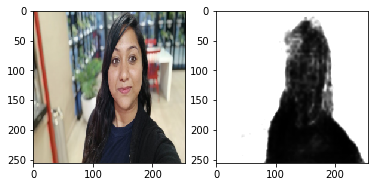

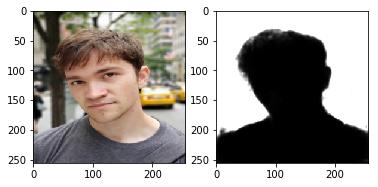

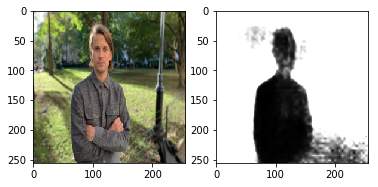

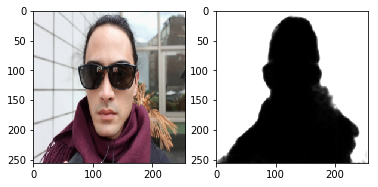

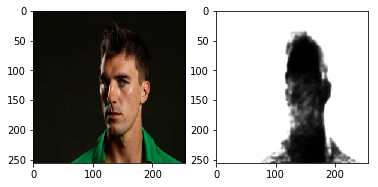

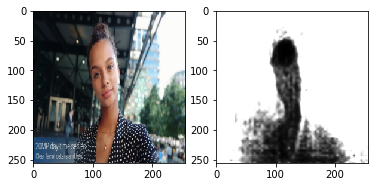

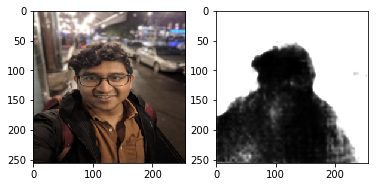

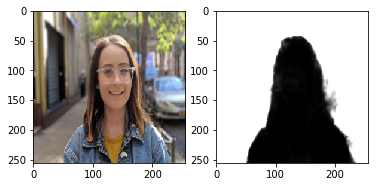

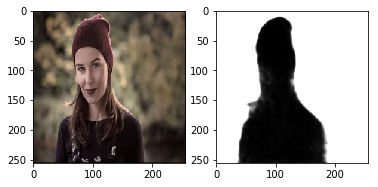

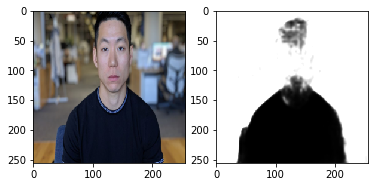

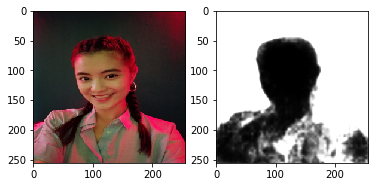

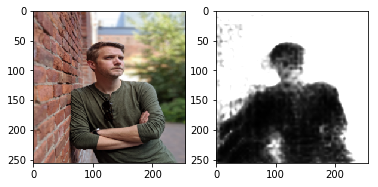

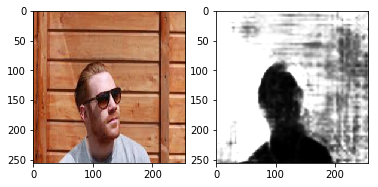

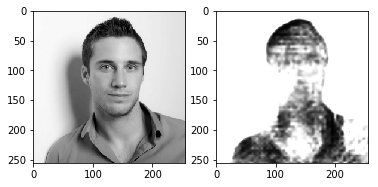

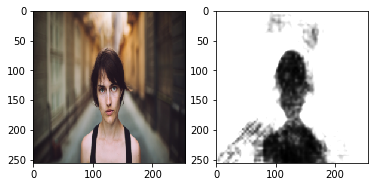

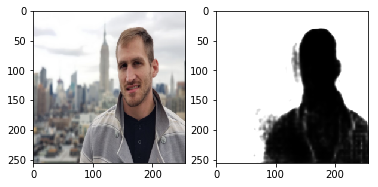

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,otp.shape,anti_aliasing=True))
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1), cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')